In [14]:
import pandas as pd
import time
from dotenv import load_dotenv
load_dotenv("./.env.local")
import os
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
# https://docs.tweepy.org/en/stable/client.html
import tweepy
client = tweepy.Client(BEARER_TOKEN, wait_on_rate_limit=True)
from pathlib import Path
import networkx as nx

# Data preprocessing

For each csv (one day = 1 csv) in the dataset folder:

    * filter to only keep english
    * only keep userid, tweetid, text, hashtags columns
    * delete duplicate based on test
    * sample 15k per day (for a total of around 200k for 2 weeks)
    * save the new df in the csvdataframes folder as day_{idx}.csv

In [5]:
# Preprocessing the datasets and save them in csv files under csvdataframes folder
Path.mkdir(Path("csvdataframes"), exist_ok=True)
Path.mkdir(Path("edgelists"), exist_ok=True)
Path.mkdir(Path("csvdataframes_wOgIds"), exist_ok=True)

In [2]:
for idx, day in enumerate(Path("dataset").iterdir()):
    full_dataset = pd.read_csv(day, compression='gzip')
    df_en = full_dataset[full_dataset['language']=='en']
    df_en_filteted = df_en[["userid", "tweetid", "text", "hashtags"]]
    df_no_duplicate = df_en_filteted.drop_duplicates(subset='text', keep='first')
    df_sampled = df_no_duplicate.sample(5)
    df_sampled.to_csv(Path(f"csvdataframes/day_{idx}.csv"))

C:\Users\Bao\AppData\Local\Temp\ipykernel_14844\929213653.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dataset = pd.read_csv(day, compression='gzip')


Because the original dataset contains retweet id, for each df in the
csvdataframes folder add a a new columns original_tweet_id with value the
original tweet id if the tweet was a retweet else keep the tweet id and save
every thing on the csvdataframes_wOgIds folder

In [7]:
def get_tweets(ids):
    tweets = client.get_tweets(ids=ids, expansions=['referenced_tweets.id'])
    return tweets

def get_original_tweets_ids(ids):
    # convert ids to list
    ids_list = ids["tweetid"].tolist()
    tweets = get_tweets(ids_list)
    original_tweet_ids = []
    for tweet in tweets.data:
        referenced_tweet = tweet.get('referenced_tweets')
        original_tweet_id = referenced_tweet[0].id if referenced_tweet else tweet.id
        original_tweet_ids.append(original_tweet_id)
    original_tweet_ids_df = pd.DataFrame(original_tweet_ids, columns=["original_tweet_id"])
    original_tweet_ids_df['Unnamed: 0'] = ids['Unnamed: 0']
    return original_tweet_ids_df

In [115]:
for idx, file in enumerate(Path("csvdataframes").iterdir()):
    print(file)
    df = pd.read_csv(file)
    # temp df to store original tweet ids
    temp_df = pd.DataFrame()
    # split df by 100 
    for i in range(0, len(df), 100):
        print(f"{file} Iteration {i}-{i+100} / {len(df)}")
        df_100 = df[i:i+100]
        original_tweet_ids_df = get_original_tweets_ids(df_100)
        # concat temp_df and original_tweet_ids_df
        temp_df = pd.concat([temp_df, original_tweet_ids_df])
    # Merge temp_df with df
    df = pd.merge(df, temp_df, on="Unnamed: 0")
    # save df to csv
    df.to_csv(Path(f"csvdataframes_wOgIds/day_{idx}.csv"), index=False)


csvdataframes\day_0.csv
csvdataframes\day_0.csv Iteration 0-100 / 5
csvdataframes\day_1.csv
csvdataframes\day_1.csv Iteration 0-100 / 5


# Edge list creation

In [8]:
# get_retweeters from 1 id and 1 pagination token
def get_retweeters(id, pagination_token=None):
    print(".", end='')
    retweeters = client.get_retweeters(id, pagination_token=pagination_token)
    next_token = retweeters.meta.get('next_token')

    if not retweeters.data:
        return None, None

    # return list of user ids
    retweeter_ids = [retweeter.id for retweeter in retweeters.data]
    return retweeter_ids, next_token

# get_all_retweeters from 1 id
def get_all_retweeters(id):
    retweeter_ids = []
    next_token = None
    while True:
        retweeter_ids_, next_token = get_retweeters(id, pagination_token=next_token)
        if retweeter_ids_ is None:
            break
        retweeter_ids += retweeter_ids_
    return retweeter_ids

In [9]:
def get_linkin_users(id, pagination_token=None):
    print(".", end='')
    retweeters = client.get_liking_users(id, pagination_token=pagination_token)
    next_token = retweeters.meta.get('next_token')

    if not retweeters.data:
        return None, None

    # return list of user ids
    retweeter_ids = [retweeter.id for retweeter in retweeters.data]
    return retweeter_ids, next_token

def get_all_linkin_users(id):
    retweeter_ids = []
    next_token = None
    while True:
        retweeter_ids_, next_token = get_linkin_users(id, pagination_token=next_token)
        if retweeter_ids_ is None:
            break
        retweeter_ids += retweeter_ids_
    return retweeter_ids

In [10]:
def create_retweeters_edgelist():
    # create empty edgelists df with column retweeter_id and tweet_id
    edgelists_df = pd.DataFrame(columns=["retweeter_id", "tweet_id"])

    # read csv files from csvdataframes_wOgIds folder
    for idx, file in enumerate(Path("csvdataframes_wOgIds").iterdir()):
        print(file)
        df = pd.read_csv(file)
        for tweetId in df['original_tweet_id']:
            print(tweetId, end='')
            retweeter_ids = get_all_retweeters(tweetId)
            # convert to df
            retweeter_ids_df = pd.DataFrame(retweeter_ids, columns=["retweeter_id"])
            # add tweetId to df
            retweeter_ids_df.insert(1, "tweet_id", tweetId)
            # concat edgelists_df and retweeter_ids_df
            edgelists_df = pd.concat([edgelists_df, retweeter_ids_df])
            print("Done")

    # save edgelists_df to csv
    edgelists_df.to_csv(Path(f"edgelists/retweeters.csv"), index=False)

    return edgelists_df

def create_liking_edgelist():
    # create empty edgelists df with column liker_id and tweet_id
    edgelists_df = pd.DataFrame(columns=["liker_id", "tweet_id"])

    # read csv files from csvdataframes_wOgIds folder
    for idx, file in enumerate(Path("csvdataframes_wOgIds").iterdir()):
        print(file)
        df = pd.read_csv(file)
        for tweetId in df['original_tweet_id']:
            print(tweetId, end='')
            liker_ids = get_all_linkin_users(tweetId)
            # convert to df
            liker_ids_df = pd.DataFrame(liker_ids, columns=["liker_id"])
            # add tweetId to df
            liker_ids_df.insert(1, "tweet_id", tweetId)
            # concat edgelists_df and liker_ids_df
            edgelists_df = pd.concat([edgelists_df, liker_ids_df])
            print("Done")

    # save edgelists_df to csv
    edgelists_df.to_csv(Path(f"edgelists/liking.csv"), index=False)

    return edgelists_df

In [11]:
edgelists_retweeters_df = create_retweeters_edgelist()
edgelists_likers_df = create_liking_edgelist()

csvdataframes_wOgIds\day_0.csv
1498270287363817478.Done
1498307410020110338..Done
1498027839991418881..Done
1498212311303168001....Done
csvdataframes_wOgIds\day_1.csv
1498281678715990026..Done
1498342105822875652..Done
1498383733296013314..Done
csvdataframes_wOgIds\day_0.csv
1498270287363817478.Done
1498307410020110338..Done
1498027839991418881..Done
1498212311303168001...............Done
csvdataframes_wOgIds\day_1.csv
1498281678715990026...Done
1498342105822875652..Done
1498383733296013314..Done


In [12]:
edgelists_retweeters_df

,retweeter_id,tweet_id
0,1149019167699304448,1498307410020110338
1,859524223471042560,1498307410020110338
2,1494482665763835904,1498307410020110338
0,2534515821,1498027839991418881
1,1497886103340302336,1498027839991418881
...,...,...
62,1251640171705090049,1498281678715990026
63,1461448568,1498281678715990026
0,1427360781318836229,1498342105822875652
1,723523364514594816,1498342105822875652


In [13]:
edgelists_likers_df

,liker_id,tweet_id
0,1305117400870744072,1498307410020110338
1,1320750183613956096,1498307410020110338
2,1427490434788384768,1498307410020110338
3,4310318953,1498307410020110338
4,1359647839,1498307410020110338
...,...,...
33,820179602,1498342105822875652
34,589227375,1498342105822875652
35,1489987455919009793,1498342105822875652
36,1483404070580731904,1498342105822875652


# First viz

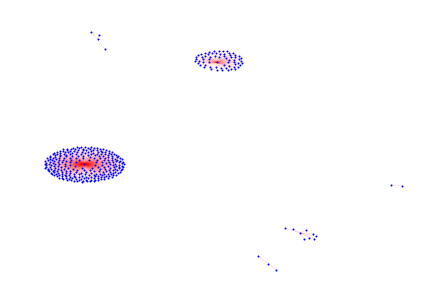

In [21]:
# load edgelists_retweeters_df to networkx
G_retweeters = nx.from_pandas_edgelist(edgelists_retweeters_df, source='retweeter_id', target='tweet_id')

# draw networkx graph with networkx and matplotlib libraries 
nx.draw(G_retweeters, with_labels=False, node_size=1, node_color='blue', edge_color='red', width=0.1)